<a href="https://colab.research.google.com/github/oldistic/fishify/blob/machine-learning/fishify_model_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.applications.xception import Xception
from google.colab import drive, files

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definisikan path dataset
train_data_dir = '/content/drive/MyDrive/capstone_project/fishify/datasets/Roboflow Dataset/train'
valid_data_dir = '/content/drive/MyDrive/capstone_project/fishify/datasets/Roboflow Dataset/valid'
# Tentukan parameter-model
batch_size = 32
image_size = (224, 224)
epochs = 25

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Persiapkan data train
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Persiapkan data validation
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 546 images belonging to 13 classes.
Found 77 images belonging to 13 classes.


In [ ]:
from tensorflow.keras import callbacks

class CustomEarlyStopping(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.85 and logs.get('accuracy') > 0.85:
            print("\nTraining is stopped as val_accuracy > 0.85, accuracy > 0.85")
            self.model.stop_training = True

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# create the base pre-trained model : Xception + global spatial average pooling
base_model = Xception(weights='imagenet', input_shape=(224, 224, 3), include_top=False, pooling='avg')

# add a global spatial average pooling layer
x = base_model.output
# let's add a fully-connected layer
x = layers.Dense(256, activation='relu')(x)
# and a logistic layer -- 18 classes
predictions = layers.Dense(13, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
opt = tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=1e-6, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit(train_generator, epochs=4, validation_data=valid_generator, verbose=1)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from Xception. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the last inception blocks, i.e. we will freeze
# the first 125 layers and unfreeze the rest:
for layer in model.layers[:125]:
    layer.trainable = False
for layer in model.layers[125:]:
    layer.trainable = True
# we need to recompile the model for these modifications to take effect
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(train_generator, epochs=4, validation_data=valid_generator, verbose=1)

83683744/83683744 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/4
18/18 [==============================] - 214s 12s/step - loss: 2.4114 - accuracy: 0.2179 - val_loss: 2.0771 - val_accuracy: 0.4286
Epoch 2/4
18/18 [==============================] - 85s 5s/step - loss: 1.8541 - accuracy: 0.5824 - val_loss: 1.6932 - val_accuracy: 0.5325
Epoch 3/4
18/18 [==============================] - 85s 5s/step - loss: 1.4579 - accuracy: 0.7399 - val_loss: 1.3813 - val_accuracy: 0.7013
Epoch 4/4
18/18 [==============================] - 95s 5s/step - loss: 1.1623 - accuracy: 0.8352 - val_loss: 1.1568 - val_accuracy: 0.7532
0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normali

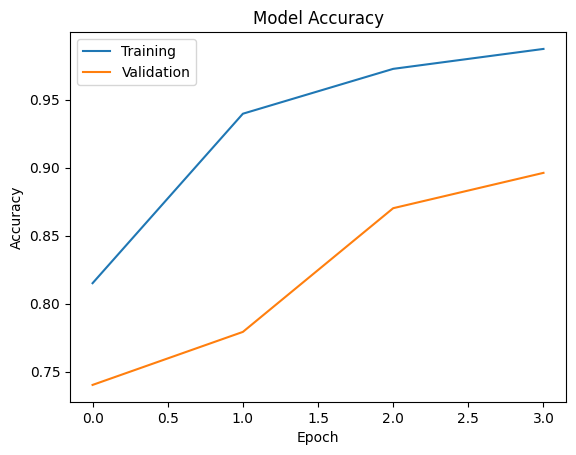

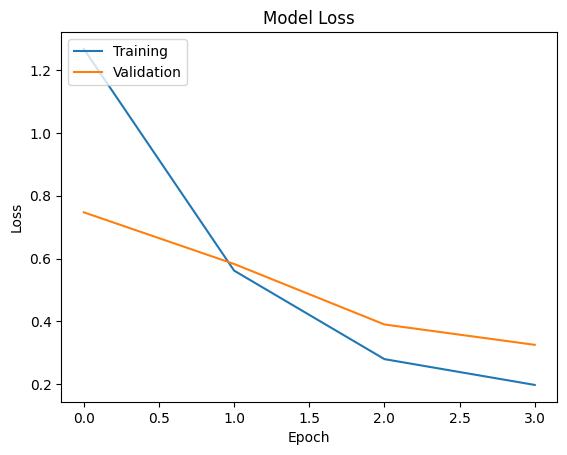

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Plot grafik loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Predict


In [ ]:
from google.colab import files

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Mendapatkan label kelas
class_labels = list(train_generator.class_indices.keys())

# Mengunggah file
uploaded_files = files.upload()

# Melakukan prediksi untuk setiap file yang diunggah
for filename in uploaded_files.keys():
    # Membuka dan memproses gambar
    img_path = filename
    img = image.load_img(img_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(img_array_expanded_dims)

    # Menumpuk gambar dan melakukan prediksi
    stacked_images = np.vstack([preprocessed_img])
    probabilities = model.predict(stacked_images)[0]

    # Menampilkan gambar dan probabilitas prediksi
    plt.imshow(img)
    plt.show()
    for (class_label, probability) in zip(class_labels, probabilities):
        print(f"{class_label}: {probability * 100:.2f}%")

In [ ]:
# Simpan model
model.save('/content/drive/MyDrive/capstone_project/fishify/model/model_v9_alif.h5')

# Convert TFLite

In [ ]:
# Load your existing model
model_path = '/content/drive/MyDrive/capstone_project/model/model_v6_rozi_10Desember.h5'
model = tf.keras.models.load_model(model_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to Google Drive
drive_path = '/content/drive/MyDrive/capstone_project/model'
tflite_model_path = 'Fishify_model.tflite'

with open(drive_path + tflite_model_path, 'wb') as f:
    f.write(tflite_model)
